In [3]:
import rasterio
import importlib
import glob
import matplotlib.pyplot as plt
from simvp import SimVP
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch
import datetime
from skimage.metrics import structural_similarity as ssim

In [4]:
import torch.nn as nn
print(torch.__version__)
print(torch.version.cuda)


2.3.0+cu121
12.1


In [5]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.device_count())         # Number of available GPUs
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0)) 


True
1
NVIDIA GeForce RTX 4050 Laptop GPU


In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

import torch
x = torch.rand(10, 10, device='cuda')
y = torch.rand(10, 10, device='cuda')
z = x + y  # Test simple operation again
print(z)


tensor([[1.1778, 0.7401, 1.5648, 1.3320, 1.0156, 0.6423, 0.7657, 0.7647, 1.1102,
         1.6785],
        [1.1552, 1.5838, 0.5165, 0.2212, 0.7895, 0.6499, 0.4941, 1.6110, 0.9352,
         1.6989],
        [1.3454, 1.4950, 0.9004, 0.6603, 0.9372, 1.1620, 1.1777, 0.6960, 0.5969,
         1.1284],
        [1.2227, 0.3594, 0.5654, 1.0809, 0.2691, 1.0872, 1.2290, 0.9935, 1.2119,
         0.9121],
        [0.7317, 1.8365, 1.0170, 1.0237, 1.0448, 0.9099, 1.0851, 0.7772, 1.0733,
         1.3794],
        [1.5767, 0.6255, 1.2866, 1.2934, 1.0435, 0.8260, 0.9755, 0.8215, 0.8435,
         0.7470],
        [0.7212, 0.5919, 1.0662, 1.5007, 0.3287, 1.5022, 1.2942, 1.4549, 0.4134,
         0.5451],
        [0.9502, 0.2043, 1.6823, 1.8590, 1.7798, 0.6053, 1.3221, 0.7414, 0.4952,
         1.1798],
        [1.3967, 0.8641, 1.4827, 0.7864, 1.3796, 1.6801, 0.6501, 1.2082, 0.4364,
         1.5742],
        [1.5797, 1.4106, 0.9609, 1.4191, 0.6682, 0.8546, 0.9963, 0.7130, 1.4392,
         1.5975]], device='c

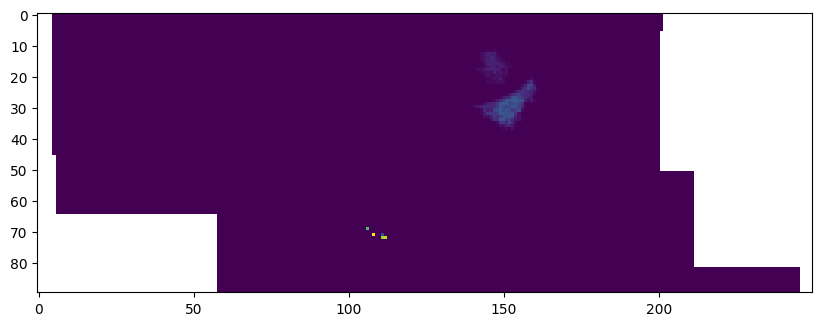

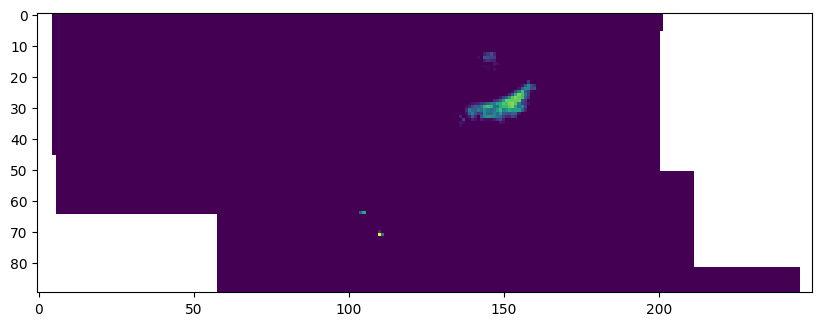

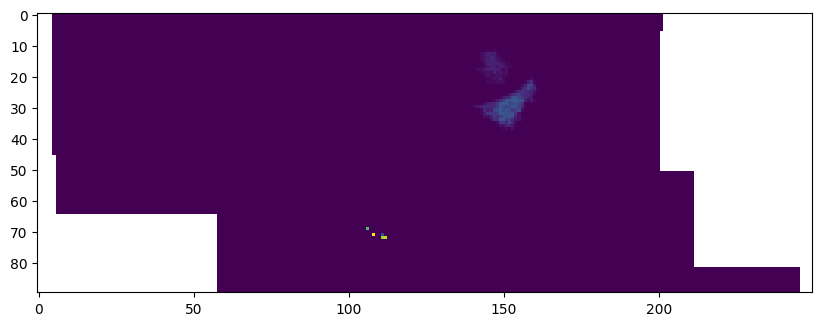

In [7]:
root_dir = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001000000.tif'
root_dir2 = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001010000.tif'
root_dir3 = r'..\DATA_SV\Precipitation\Radar\2019\10\01\Radar_20191001020000.tif'
img = rasterio.open(root_dir)
data = img.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data)
img2 = rasterio.open(root_dir2)
data2 = img2.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data2)
img3 = rasterio.open(root_dir3)
data3 = img.read(1)  # Read the only band
plt.figure(figsize=(10, 10))
plt.imshow(data3)

In [8]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def hook(module, input, output):
    if torch.isnan(output).any():
        print(f"NaNs in {module}")

# Cell 2: Helper Functions
def clean_data(data):
    data[np.isinf(data)] = np.finfo(np.float32).max
    data[np.isnan(data)] = 0
    return data

def inspect_raw_data(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(np.float32)
        has_nans = np.isnan(data).any()
        has_infs = np.isinf(data).any()
        print(f"File: {file_path} - Contains NaNs: {has_nans}, Contains Infs: {has_infs}")


In [9]:
import numpy as np
import torch
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import rasterio

def print_stats(data, name):
    # Check if data contains any infinite or NaN values and provide statistics
    finite_data = np.isfinite(data)
    if finite_data.all():
        print(f'{name} - Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, Std: {data.std()}')
    else:
        finite_only = data[finite_data]  # Filter out non-finite values for stats
        print(f'{name} contains non-finite values: Min: {finite_only.min()}, Max: {finite_only.max()}, Mean: {finite_only.mean()}, Std: {finite_only.std()}')

def clean_data(data):
    """Replace inf and NaN values with the mean of finite values in the array."""
    if not np.isfinite(data).all():
        finite_mean = np.nanmean(data[np.isfinite(data)])  # Mean of finite values
        data = np.nan_to_num(data, nan=finite_mean, posinf=finite_mean, neginf=finite_mean)
    return data

class RadarTIFFDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.transform = transforms.Compose([
            transforms.Lambda(lambda x: clean_data(x)),  # Clean data before any other transformation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_paths) - 2  # Ensure we have enough files for a sequence

    def __getitem__(self, idx):
        with rasterio.open(self.file_paths[idx]) as img1:
            x1 = img1.read(1).astype(np.float32)
            print_stats(x1, "Before transformation X1")
            x1 = self.transform(x1)

        with rasterio.open(self.file_paths[idx + 1]) as img2:
            x2 = img2.read(1).astype(np.float32)
            x2 = self.transform(x2)

        with rasterio.open(self.file_paths[idx + 2]) as img3:
            y = img3.read(1).astype(np.float32)
            y = self.transform(y)

        x = torch.stack([x1, x2], dim=0)
        return x, y

# Usage Example
file_paths = [
    '../DATA_SV/Precipitation/Radar/2019/10/01/Radar_20191001000000.tif',
    '../DATA_SV/Precipitation/Radar/2019/10/01/Radar_20191001010000.tif',
    '../DATA_SV/Precipitation/Radar/2019/10/01/Radar_20191001020000.tif'
]



def get_radar_file_paths(year, months, base_path):
    """Gets file paths for radar data using pathlib and replaces backslashes."""
    all_files = []
    base_dir = Path(base_path)
    for month in months:
        month_dir = base_dir / str(year) / f"{month:02d}"
        for day in range(1, 32):
            try:
                day_dir = month_dir / f"{day:02d}"
                tif_files = list(day_dir.glob("*.tif")) 

                # Replace backslashes and convert to strings
                tif_files = [str(p).replace("\\", "/") for p in tif_files] 
                all_files.extend(tif_files)
            except ValueError:
                pass
    return all_files

# Example usage
base_path = '../DATA_SV/Precipitation/Radar'
years = [2019]  # You can add more years if needed
months = [4, 10]

all_file_paths = []
for year in years:
    all_file_paths.extend(get_radar_file_paths(year, months, base_path))

print(all_file_paths)  # Print the first 5 file paths for demonstration

dataset = RadarTIFFDataset(all_file_paths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for x, y in dataloader:
    print("Input shape:", x.shape)  # Expect [batch_size, 2, 1, Height, Width]
    print("Output shape:", y.shape)  # Expect [batch_size, 1, Height, Width]


['../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401000000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401010000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401020000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401030000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401040000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401050000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401060000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401070000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401080000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401090000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401100000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401110000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401120000.tif', '../DATA_SV/Precipitation/Radar/2019/04/01/Radar_20190401130000.tif', '../DATA_SV/Precipi

In [10]:
# # Assuming the necessary dimensions for hid and enc1 based on your network architecture
# from simvp import Decoder
# dummy_hid = torch.randn(1, 256, 60, 160)  # Adjust the size according to your Decoder's input requirements
# dummy_enc1 = torch.randn(1, 256, 60, 160)  # Same here, assuming you use enc1

# # Instantiate Decoder
# decoder = Decoder(C_hid=256, C_out=1, N_S=5)  # Use actual values from your implementation
# print("Decoder initialized successfully")
# # Test the Decoder
# output = decoder(dummy_hid, dummy_enc1)


In [11]:
from torch.optim import Adam

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Change based on your activation
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Adjust accordingly
        if m.bias is not None:
            nn.init.zeros_(m.bias)
def check_nan_inf(data, name="Data"):
    if torch.isnan(data).any():
        print(f'{name} contains NaNs')
    if torch.isinf(data).any():
        print(f'{name} contains Infs')


save_dir = '../save'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimVP(shape_in=(2, 3, 128, 128)).to(device)
model.apply(init_weights)
optimizer = Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()
num_epochs = 20

# for epoch in range(num_epochs):
#     for x, y_true in dataloader:
#         x, y_true = x.to(device), y_true.to(device)
#         optimizer.zero_grad()
#         y_pred = model(x)

#         check_nan_inf(x, "Input x")
#         check_nan_inf(y_true, "Target y_true")
#         if y_pred.size() != y_true.size():
#             y_true = y_true.repeat(1, 2, 1, 1, 1)  

#         check_nan_inf(y_pred, "Model output y_pred")

#         loss = criterion(y_pred, y_true)
#         # Check before backward pass
#         if not torch.isfinite(loss):
#             print("Loss is not finite. Stopping:")
#             print("Loss:", loss)
#             break

#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
#         optimizer.step()

#         if torch.isnan(loss):
#             print("NaN loss detected")
#             break

#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')
#     model_save_path = os.path.join(save_dir, f'model_epoch_{epoch}.pth')
#     torch.save(model.state_dict(), model_save_path)
#     print(f'Model saved for epoch {epoch} at {model_save_path}')


torch.Size([1, 2, 1, 90, 250])
Shape after each Decoder step: torch.Size([2, 16, 92, 252])
Shape after resizing hid: torch.Size([2, 16, 90, 250])
Shape after resizing enc1: torch.Size([2, 16, 90, 250])
Shape before final readout: torch.Size([2, 16, 90, 250])
Non-finite values detected in predictions.
Prediction is clean.


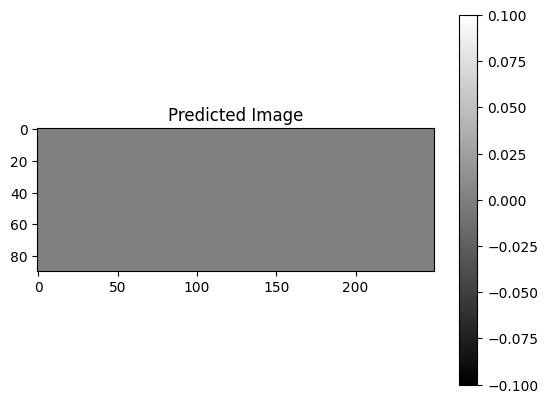

Current datetime from input file: 2019-10-01 22:00:00
Predicted datetime for next frame: 2019-10-02 00:00:00


In [12]:
import datetime
import torch
# Helper function to extract date and time from filename
def extract_datetime_from_filename(filename):
    # Extract the timestamp part from the filename
    timestamp_str = filename.split('_')[-1].split('.')[0]
    # Convert to datetime object
    timestamp = datetime.datetime.strptime(timestamp_str, '%Y%m%d%H%M%S')
    return timestamp

# Define function to predict next timestamp
def predict_next_datetime(current_datetime, time_step_minutes=120):
    return current_datetime + datetime.timedelta(minutes=time_step_minutes)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_file_path = '../DATA_SV/Precipitation/Radar/2019/10/01/Radar_20191001220000.tif'

# Ensure the path exists (especially on Linux/macOS)
if os.path.exists(input_file_path):
    with rasterio.open(input_file_path) as src:
        input_data = src.read(1)
else:
    print("Error: File not found. Please check the path.")

input_data = input_data.astype(np.float32)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformation
input_tensor = transform(input_data)
input_tensor = torch.stack([input_tensor, input_tensor], dim=0) 
input_tensor = input_tensor.unsqueeze(0).to(device) 

# Load the model
model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
model.load_state_dict(torch.load('../save/model_epoch_10.pth'))
model.eval()

# Predict and visualize
with torch.no_grad():
    prediction = model(input_tensor)

# Checking for non-finite values in predictions
finite_mask = torch.isfinite(prediction)
if not finite_mask.all():
    print("Non-finite values detected in predictions.")
    prediction[~finite_mask] = 0  # Replace non-finite values with zero or some appropriate value

predicted_image = prediction.squeeze().cpu().numpy()
if np.isfinite(predicted_image).all():
    print("Prediction is clean.")
    plt.imshow(predicted_image[0], cmap='gray')  
    plt.colorbar()
    plt.title("Predicted Image")
    plt.show()
else:
    print("Still contains non-finite values after correction.")

current_datetime = extract_datetime_from_filename(input_file_path)
print("Current datetime from input file:", current_datetime)

predicted_datetime = predict_next_datetime(current_datetime)
print("Predicted datetime for next frame:", predicted_datetime)


Input Data contains non-finite values. Finite stats - Min: 0.0, Max: 7.8125, Mean: 0.013938643038272858, Std: 0.19489404559135437
torch.Size([1, 2, 1, 90, 250])
Shape after each Decoder step: torch.Size([2, 16, 92, 252])
Shape after resizing hid: torch.Size([2, 16, 90, 250])
Shape after resizing enc1: torch.Size([2, 16, 90, 250])
Shape before final readout: torch.Size([2, 16, 90, 250])
Predicted Image - Min: -27.151222229003906, Max: 5.5674614906311035, Mean: -1.4421038627624512, Std: 0.6261398196220398


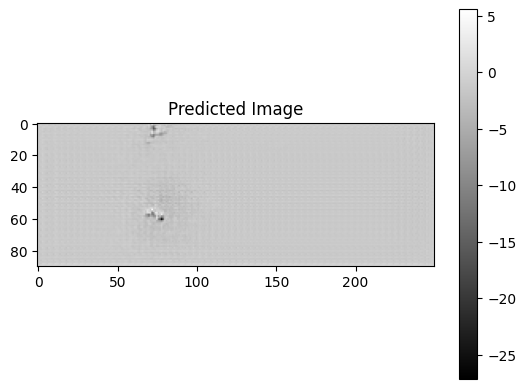

Current datetime from input file: 2019-10-01 22:00:00
Predicted datetime for next frame: 2019-10-01 23:00:00
Actual Data contains non-finite values. Finite stats - Min: 0.0, Max: 14.0, Mean: 0.008374735713005066, Std: 0.20993629097938538
MSE: 2.4197, PSNR: -3.84 dB, SSIM: -0.0000


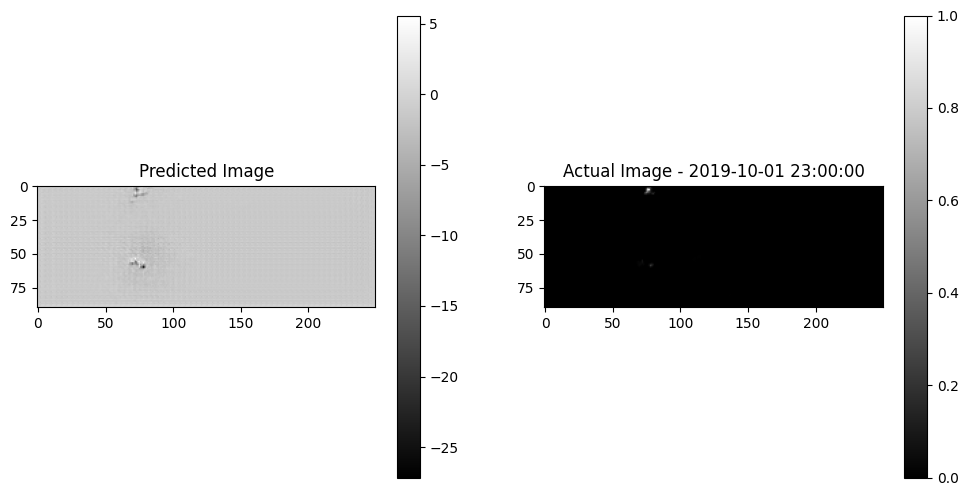

In [13]:
import rasterio
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from skimage.metrics import structural_similarity as ssim

def print_stats(data, name):
    finite_data = np.isfinite(data)
    if finite_data.all():
        print(f'{name} - Min: {data.min()}, Max: {data.max()}, Mean: {data.mean()}, Std: {data.std()}')
    else:
        finite_vals = data[finite_data]
        print(f'{name} contains non-finite values. Finite stats - Min: {finite_vals.min()}, Max: {finite_vals.max()}, Mean: {finite_vals.mean()}, Std: {finite_vals.std()}')

def clean_data(data):
    data = np.clip(data, a_min=0, a_max=np.finfo(np.float32).max)
    data[np.isnan(data)] = np.mean(data[np.isfinite(data)]) if np.isfinite(data).any() else 0
    return data

def extract_datetime_from_filename(file_path):
    filename = os.path.basename(file_path)  # Use os.path.basename for cross-platform compatibility
    datetime_str = filename.split('_')[1].split('.')[0]  # Extract datetime string
    return datetime.strptime(datetime_str, "%Y%m%d%H%M%S")

def predict_next_datetime(current_datetime):
    return current_datetime + timedelta(hours=1)

def compute_metrics(prediction, ground_truth):
    mse = np.mean((prediction - ground_truth) ** 2)
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    ssim_index = ssim(prediction, ground_truth, data_range=ground_truth.max() - ground_truth.min())
    return mse, psnr, ssim_index

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load input data
input_file_path = '/study/school-project/AI/qpn-simvp/DATA_SV/Precipitation/Radar/2019/10/01/Radar_20191001220000.tif'

with rasterio.open(input_file_path) as src:
    input_data = src.read(1).astype(np.float32)
    print_stats(input_data, "Input Data")
    input_data = clean_data(input_data)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

input_tensor = transform(input_data)
input_tensor = torch.stack([input_tensor, input_tensor], dim=0)
input_tensor = input_tensor.unsqueeze(0).to(device)

# Load the model
model = SimVP(shape_in=(2, 1, 90, 250)).to(device)
model.load_state_dict(torch.load('/study/school-project/AI/qpn-simvp/save/model_epoch_19.pth'))
model.eval()

# Predict and visualize
with torch.no_grad():
    prediction = model(input_tensor)

# Checking for non-finite values in predictions
finite_mask = torch.isfinite(prediction)
if not finite_mask.all():
    print("Non-finite values detected in predictions.")
    prediction[~finite_mask] = 0

predicted_image = prediction.squeeze().cpu().numpy()
print_stats(predicted_image, "Predicted Image")

plt.imshow(predicted_image[0], cmap='gray')
plt.colorbar()
plt.title("Predicted Image")
plt.show()

# Compute metrics
current_datetime = extract_datetime_from_filename(input_file_path)
predicted_datetime = predict_next_datetime(current_datetime)
print("Current datetime from input file:", current_datetime)
print("Predicted datetime for next frame:", predicted_datetime)

actual_file_path = f'/study/school-project/AI/qpn-simvp/DATA_SV/Precipitation/Radar/{predicted_datetime.year}/{predicted_datetime.month:02d}/{predicted_datetime.day:02d}/Radar_{predicted_datetime.strftime("%Y%m%d%H%M%S")}.tif'

try:
    with rasterio.open(actual_file_path) as src:
        actual_data = src.read(1).astype(np.float32)
        print_stats(actual_data, "Actual Data")
        actual_data = clean_data(actual_data)
        actual_data = (actual_data - actual_data.min()) / (actual_data.max() - actual_data.min())
    
    mse, psnr, ssim_index = compute_metrics(predicted_image[0], actual_data)
    print(f'MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_index:.4f}')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_image[0], cmap='gray')
    plt.colorbar()
    plt.title("Predicted Image")

    plt.subplot(1, 2, 2)
    plt.imshow(actual_data, cmap='gray')
    plt.colorbar()
    plt.title(f"Actual Image - {predicted_datetime}")
    plt.show()
except FileNotFoundError:
    print(f"Actual next image file not found: {actual_file_path}")


Precision: 0.1000, CSI: 0.0714, RMSE: 1.5555


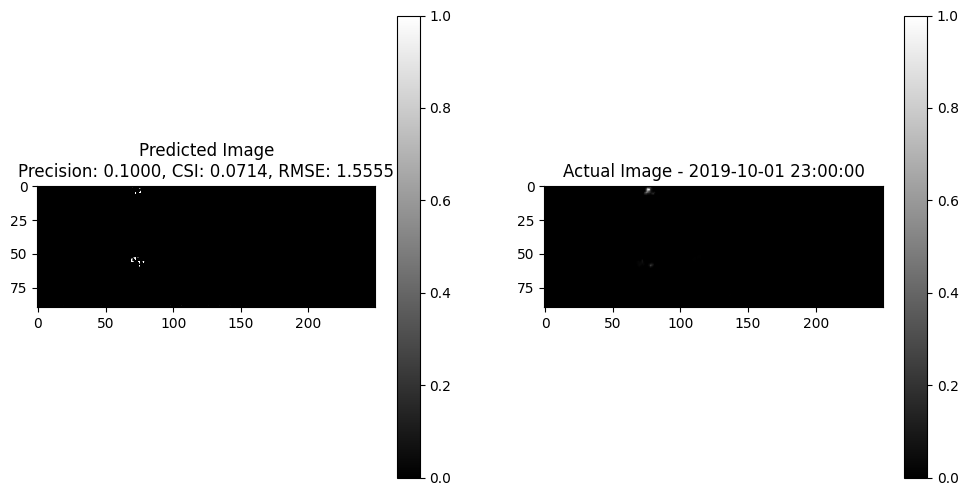

In [14]:
import numpy as np
from sklearn.metrics import precision_score, confusion_matrix

# Define a function to compute Precision, CSI, and RMSE
def compute_metrics(prediction, ground_truth, threshold=0.1):
    # Flatten the arrays to compute metrics
    pred_flat = prediction.flatten()
    gt_flat = ground_truth.flatten()
    
    # Binarize predictions and ground truth based on threshold
    pred_binary = (pred_flat >= threshold).astype(int)
    gt_binary = (gt_flat >= threshold).astype(int)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(gt_binary, pred_binary).ravel()
    
    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Critical Success Index (CSI)
    csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred_flat - gt_flat) ** 2))
    
    return precision, csi, rmse

# Use the provided data for metric calculation
# Ensure predicted_image and actual_data are the same size and normalized

# Assuming predicted_image and actual_data are already defined
mse, psnr, ssim_index = compute_metrics(predicted_image[0], actual_data)
precision, csi, rmse = compute_metrics(predicted_image[0], actual_data)

print(f'Precision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}')

# Plot the images and display metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(predicted_image[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title(f"Predicted Image\nPrecision: {precision:.4f}, CSI: {csi:.4f}, RMSE: {rmse:.4f}")

plt.subplot(1, 2, 2)
plt.imshow(actual_data, cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title(f"Actual Image - {predicted_datetime}")
plt.show()
